In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group

## Random walk on a matrix

In [2]:
k = 0.01
n_dims = 3
num_iterations = 1000
norm = 'fro'

start_norms = []
diff_norms = []
start_norms_inv = []
diff_norms_inv = []
condition_numbers = []

In [3]:
start_matrix = 100 + ortho_group.rvs(dim=n_dims)
start_matrix_inverse = np.linalg.inv(start_matrix)
m1 = start_matrix
m1_inv = start_matrix_inverse

In [4]:
for _ in range(num_iterations):
    dm = k * np.random.randn(*start_matrix.shape)
    m2 = m1 + dm
    m2_inv =np.linalg.inv(m2)
    
    start_norms.append(np.linalg.norm(start_matrix - m2, ord=norm))
    diff_norms.append(np.linalg.norm(m2 - m1, ord='fro'))
    
    start_norms_inv.append(np.linalg.norm(start_matrix_inverse - m2_inv, ord=norm))
    diff_norms_inv.append(np.linalg.norm(m2_inv - m1_inv, ord=norm))
    
    condition_numbers.append(np.linalg.cond(m1, p=norm))
    
    m1 = m2
    m1_inv = m2_inv

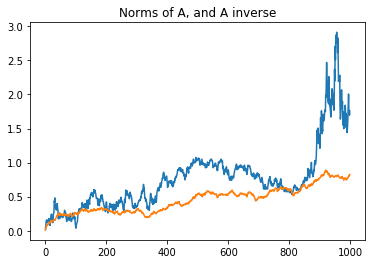

In [5]:
plt.plot(start_norms_inv)
plt.plot(start_norms)
plt.title('Norms of A, and A inverse');

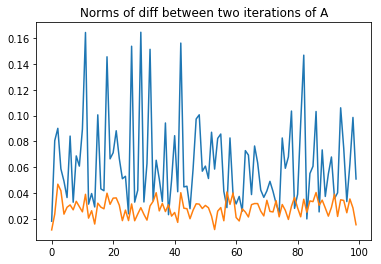

In [6]:
plt.plot(diff_norms_inv[:100])
plt.plot(diff_norms[:100])
plt.title('Norms of diff between two iterations of A');

Text(0.5,1,'Condition number')

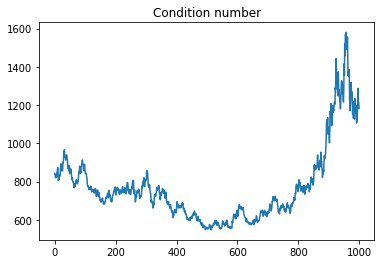

In [7]:
plt.plot(condition_numbers)
plt.title('Condition number')

## Train a neural network to predict the inverse

In [190]:
def generate_dataset(n_examples, n_dims):
    matrices = []
    inverses = []
    for _ in range(n_examples):
        matrix = np.random.randn(n_dims, n_dims)
        matrices.append(matrix.reshape(-1))
        inverses.append(np.linalg.inv(matrix).reshape(-1))
    
    matrices = np.stack(matrices, axis=0)
    inverses = np.stack(inverses, axis=0)

    return matrices, inverses

In [191]:
n_dims = 2
n_examples = 1000
X, y = generate_dataset(n_examples=n_examples, n_dims=n_dims)

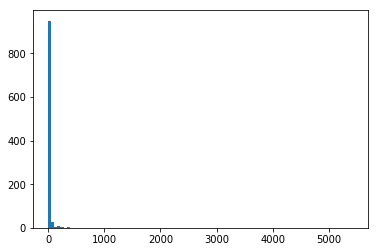

In [195]:
condition_numbers = [np.linalg.cond(X[i].reshape(n_dims, n_dims)) for i in range(X.shape[0])]
plt.hist(condition_numbers, bins=100);

In [215]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def get_model():
    model = Sequential()
    model.add(Dense(100, input_shape=(n_dims**2, ), activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(n_dims**2, activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(lr=1e-3))

    return model

In [216]:
#model = get_model()

In [320]:
hist = model.fit(X, y, epochs=1000, verbose=False, batch_size=256)

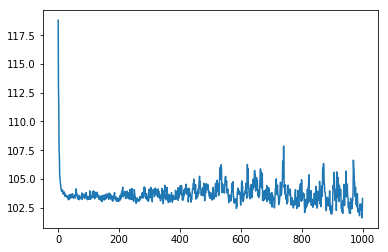

In [321]:
plt.plot(hist.history['loss'])

In [312]:
X_val, y_val = generate_dataset(n_examples=10, n_dims=n_dims)

In [313]:
y_pred = model.predict(X)

In [314]:
y_pred[0]

array([ 20.132158 , -23.020119 ,   7.4155364,  -1.4044714], dtype=float32)

In [315]:
y[0]

array([ 2.99120375, -2.83447406,  1.16529174, -2.16338761])

## Solving OLS using NN instead of matrix inverse

In [168]:
def add_constant_column(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)

def generate_ols_data(n_examples, n_features, sigma=0.1):
    k = 0.5 - np.random.rand(n_features + 1, 1)
    x = 0.001 * np.random.rand(n_examples, n_features)
    x = add_constant_column(x)
    noise = sigma * np.random.randn(n_examples, 1)
    y = np.dot(x, k) + noise
    return x, y, noise, k

In [175]:
def least_squares(x, y):
    xdx = np.dot(x.T, x)
    xdx_normalized = xdx / xdx.max()
    inv = model.predict(xdx_normalized.reshape(1, -1))
    inv = inv / xdx.max()
    n_dims = int(np.sqrt(inv.shape[1]))
    inv = inv.reshape(n_dims, n_dims)
    print(inv), print(np.linalg.inv(xdx))
    print(np.linalg.cond(xdx))
    inv_x = np.dot(inv, x.T)
    p = np.dot(inv_x, y)
    
    return p

In [176]:
X, y, _, k = generate_ols_data(n_examples=4, n_features=n_dims - 1, sigma=0.01)

In [177]:
least_squares(X, y)

[[ 0.10391965 -0.0708696 ]
 [-0.07767674 -0.17954281]]
[[ 1.70911503e+01 -2.07361833e+04]
 [-2.07361833e+04  2.55320624e+07]]
102128384.13371083


array([[ 0.18915474],
       [-0.14173077]])

In [178]:
X.shape

(4, 2)

In [179]:
X, y = generate_dataset(1, 3)

In [180]:
print(np.linalg.inv(X.reshape(3, 3)))
print(np.linalg.inv(X.reshape(3, 3) / 2))

[[ 0.55156816 -0.09818692 -0.82833079]
 [-0.81113025 -0.29472263 -0.50517947]
 [ 0.19452581 -0.95052506  0.242202  ]]
[[ 1.10313632 -0.19637385 -1.65666158]
 [-1.62226049 -0.58944526 -1.01035894]
 [ 0.38905162 -1.90105013  0.48440401]]
